In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossBinary, DiceLoss

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
class FocalLossMultiClass(FocalLossBinary):
    """
    Compute focal loss for multi-class problem.
    Ignores targets having -1 label
    """
    eps=1e-10
    def to_onehot(self, indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
                             dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.unsqueeze(1), 1)

    def forward(self, logits, targets):
        """
        Args:
            logits: [bs; num_classes; ...]
            targets: [bs; ...]
        """
        num_classes = logits.size(1)
        loss = 0
        # one hot encode 
#         targets = self.to_onehot(targets.view(-1), num_classes=num_classes)
        logits = logits.view(-1, num_classes)
        
        print(targets.shape, logits.shape)
        

        # Filter anchors with -1 label from loss computation
        if self.ignore is not None:
            not_ignored = targets != self.ignore

        for cls in range(num_classes):
            cls_label_target = (targets == (cls + 0)).long()
            cls_label_input = logits[..., cls]

            if self.ignore is not None:
                cls_label_target = cls_label_target[not_ignored]
                cls_label_input = cls_label_input[not_ignored]

            loss += self.loss_fn(cls_label_input, cls_label_target)

        return loss

In [3]:
fc_loss =  FocalLossMultiClass()
d_loss = DiceLoss()

def focal_dice_loss(logits, targets):
    focal_loss = fc_loss(logits, targets)
    dice_loss = d_loss(logits, targets)
    
    return 0.8 * focal_loss + 0.2 * dice_loss

In [4]:
data_dir = Path("/media/wwymak/Storage/xView2")
models_path = data_dir / "models"
classifcation_crop_dir = data_dir/"classification_crops"
classification_labels = pd.read_csv(data_dir/"train.csv")

In [5]:
classification_labels.head()

,uuid,img_id,label,crop_filename
0,c18d34cd-d48d-43ba-9d9c-011b6f9d5eb8,palu-tsunami_00000024_post_disaster.png,0,c18d34cd-d48d-43ba-9d9c-011b6f9d5eb8.png
1,4db83f7b-7c77-4cb4-8ea7-ad5a338a92b1,palu-tsunami_00000024_post_disaster.png,0,4db83f7b-7c77-4cb4-8ea7-ad5a338a92b1.png
2,fc34426b-db11-403d-bdcf-1527b7d2508a,palu-tsunami_00000024_post_disaster.png,0,fc34426b-db11-403d-bdcf-1527b7d2508a.png
3,052f9f14-e32e-484a-811d-cd0fac134493,palu-tsunami_00000024_post_disaster.png,0,052f9f14-e32e-484a-811d-cd0fac134493.png
4,577576f3-3bdc-41ec-a571-6f6cf843cf3b,palu-tsunami_00000024_post_disaster.png,0,577576f3-3bdc-41ec-a571-6f6cf843cf3b.png


In [6]:
def get_train_valid_ids(classification_labels_df, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df.img_id.unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df.img_id.isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df.img_id.isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids
    

In [7]:
train_ids, valid_ids = get_train_valid_ids(classification_labels)

In [8]:
classification_labels_resampled= pd.concat([
    classification_labels[(classification_labels.label!= 0) & (~classification_labels.crop_filename.isin(valid_ids))],
    classification_labels[(classification_labels.label==0) & (~classification_labels.crop_filename.isin(valid_ids))].sample(frac=0.2),
    classification_labels[classification_labels.crop_filename.isin(valid_ids)],
])
classification_labels_resampled.label.value_counts(normalize=True), classification_labels_resampled[(~classification_labels.crop_filename.isin(valid_ids))].label.value_counts(normalize=True), 

(0    0.445619
 1    0.196012
 2    0.185295
 3    0.173074
 Name: label, dtype: float64, 0    0.358821
 1    0.225587
 2    0.215748
 3    0.199844
 Name: label, dtype: float64)

In [30]:
classification_labels_resampled.shape

(76424, 4)

In [9]:

def is_valid_func(img_fname):
    id = Path(img_fname).name
    return id in valid_ids


In [10]:

def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.unsqueeze(1), 1)
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#


In [11]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class myCCELoss(nn.Module):

    def __init__(self):
        super(myCCELoss, self).__init__()

    def forward(self, input, target):
        y = one_hot_embedding(target, input.size(-1))
        logit = F.softmax(input)
       
        loss = -1 * V(y) * torch.log(logit) # cross entropy loss
        return loss.sum(dim=1).mean()
    
class FocalLoss(nn.Module):

    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        
    def to_onehot(self, indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.unsqueeze(1), 1)

    def forward(self, input, target, **kwargs):
        y = self.to_onehot(target, input.size(-1))
        logit = F.softmax(input)
        logit = logit.clamp(self.eps, 1. - self.eps)
        loss = F.binary_cross_entropy(logit.float(), y.float())
#         loss = -1 * V(y) * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss
        return loss.sum(dim=1).mean()


In [12]:
size=64
bs=32
src = (ImageList
       .from_df(classification_labels, path=classifcation_crop_dir, cols=['crop_filename'])
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))

data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

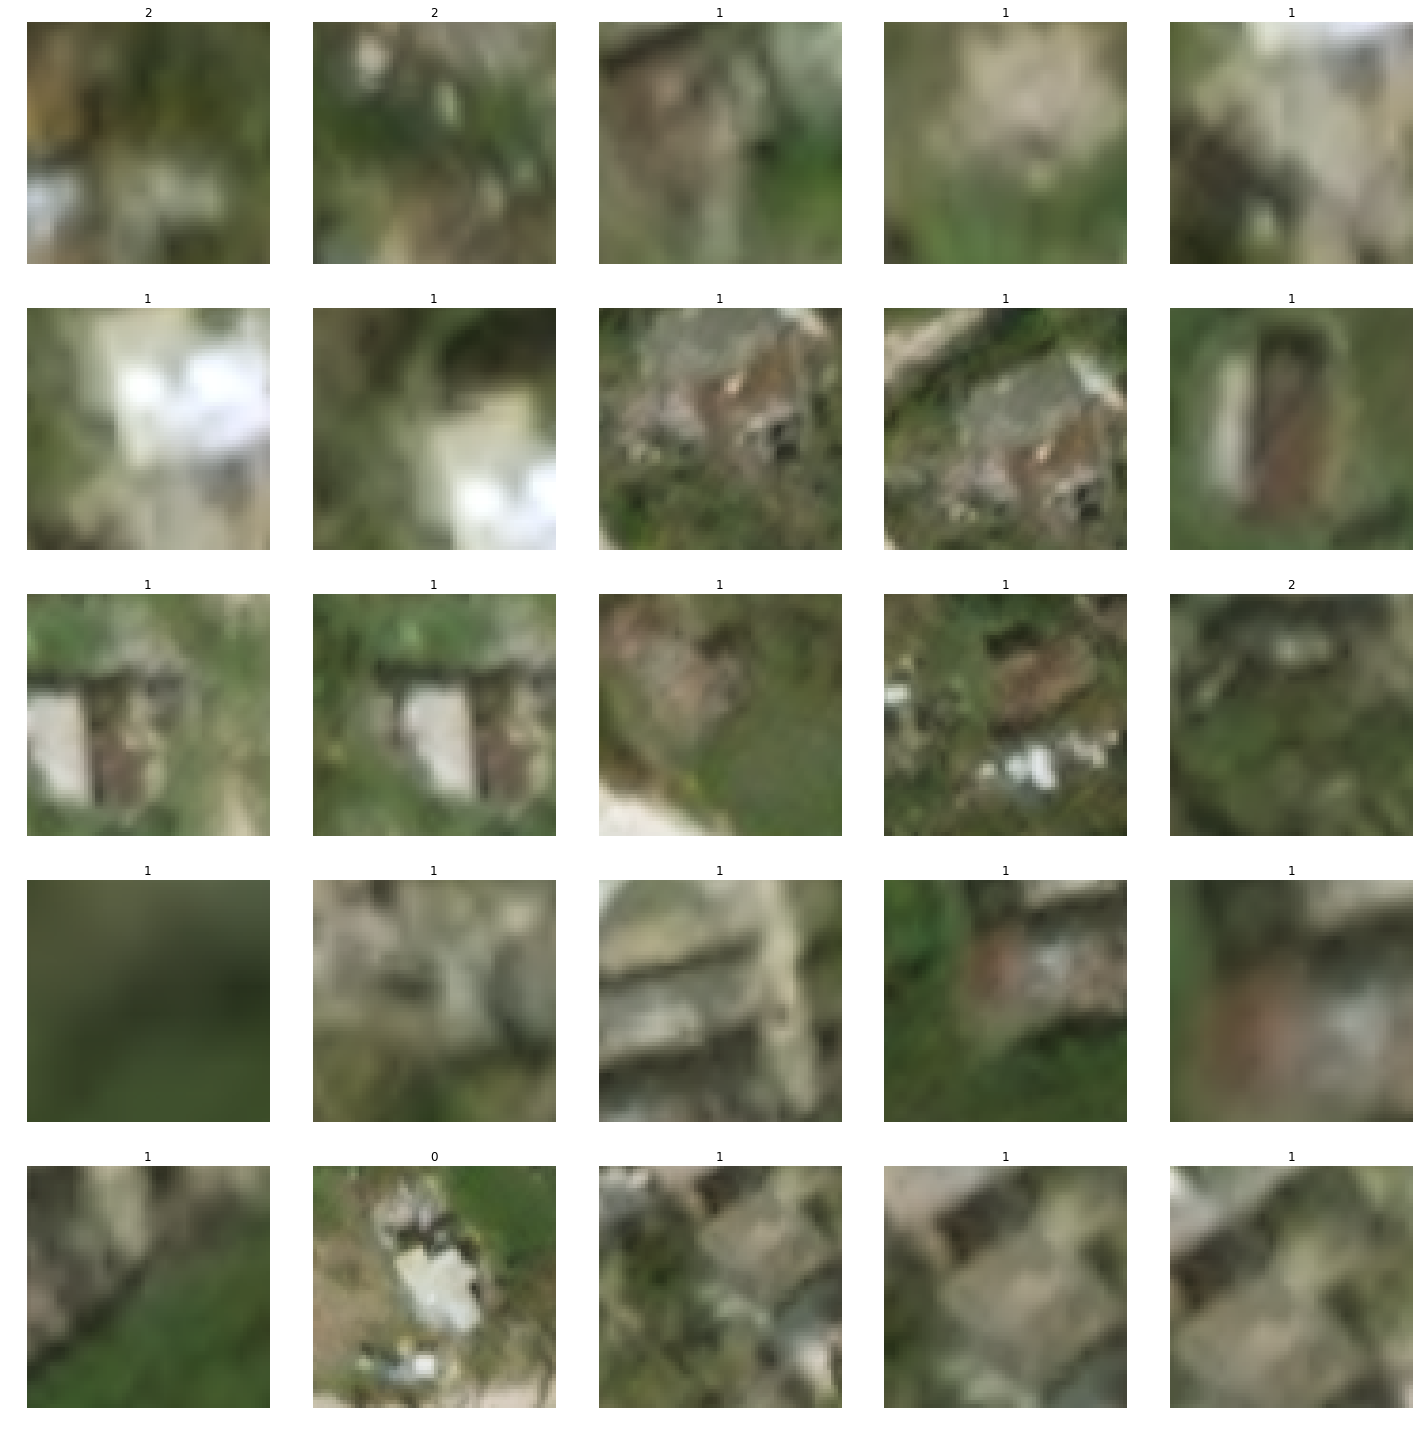

In [16]:
data.show_batch(ds_type=DatasetType.Valid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


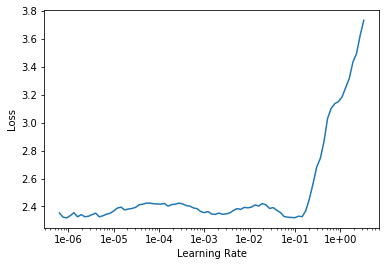

In [33]:

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.loss_func =FocalLoss(gamma=2.0)
learn.lr_find()
learn.recorder.plot()



In [34]:
learn.fit_one_cycle(1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.685949,0.599602,0.818484,0.750922,03:27


In [35]:
learn.model_dir = models_path
learn.save('25Nov-classification_focal_loss_undersampling')

In [36]:
learn.to_fp16()
learn.fit_one_cycle(3, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.642140,0.581042,0.822114,0.766877,04:28
1,0.618884,0.571432,0.827652,0.773042,04:31
2,0.613995,0.565722,0.830298,0.768939,04:29


In [37]:
learn.save('25Nov-classification_focal_loss_undersampling')

In [18]:
learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =FocalLoss(gamma=2.0)
learn.to_fp16()
learn.load('25Nov-classification_focal_loss_undersampling');

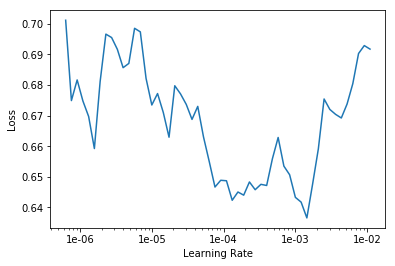

In [23]:
# learn.lr_find()
learn.recorder.plot(skip_end=20)

In [24]:
lr=1e-5
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='25Nov-classification_focal_loss_undersampling'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.588219,0.563998,0.829929,0.774258,17:46
1,0.638214,0.566975,0.829559,0.770515,04:28
2,0.637153,0.563359,0.830359,0.764318,04:38
3,0.595137,0.569159,0.828083,0.769212,04:44
4,0.617837,0.563692,0.831344,0.771147,04:38


Better model found at epoch 0 with f1 value: 0.7742579579353333.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


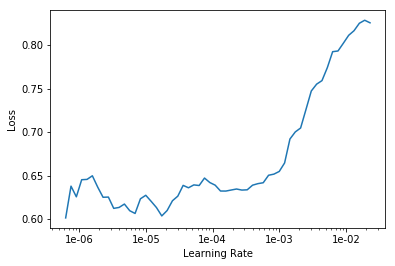

In [25]:
learn.load('25Nov-classification_focal_loss_undersampling')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=20)

In [26]:
lr=1e-6
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='24Nov-classification_focal_loss_unfrozen'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn.fit_one_cycle(10, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.642939,0.561028,0.830421,0.775608,06:01
1,0.664047,0.565421,0.830113,0.767772,06:01
2,0.600638,0.566493,0.829929,0.771508,06:04
3,0.612836,0.560576,0.831282,0.773311,06:04
4,0.598796,0.561581,0.831221,0.769667,06:03
5,0.614168,0.559119,0.831036,0.771065,06:04
6,0.637115,0.560728,0.830605,0.773286,06:06
7,0.619611,0.560670,0.830667,0.781874,06:11
8,0.624322,0.559758,0.830421,0.776736,06:07
9,0.592029,0.562602,0.831959,0.770023,06:01


Better model found at epoch 0 with f1 value: 0.7756080627441406.
Better model found at epoch 7 with f1 value: 0.7818740606307983.


In [13]:
src = (ImageList
       .from_df(classification_labels, path=classifcation_crop_dir, cols=['crop_filename'])
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))

data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [14]:
damage_crops_test_folder = data_dir / "classification_crops_test"
data2 = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data2,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =FocalLoss(gamma=2.0)
learn.to_fp16()
learn.load('24Nov-classification_focal_loss_unfrozen');


In [15]:
predictions, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
y = torch.argmax(predictions, dim=1)

In [23]:
labels = pd.read_csv(data_dir/"test_polygons.csv")
labels["crop_filename"] = labels.polygon_id.apply(lambda x: f"{x}.png")

polygon_ids = [x.name.replace('.png', '') for x in data2.test_dl.dataset.items]
prediction_cls = [x+1 for x in y.numpy()]

test_results = pd.DataFrame(data={'polygon_id': polygon_ids, 'damage_cls': prediction_cls})
test_results = labels.merge(test_results, left_on='polygon_id', right_on='polygon_id')
test_results.geometry = test_results.geometry.apply(lambda x: wkt.loads(x).exterior)
test_results.img_id = test_results.img_id.str.replace('localization', 'damage')

test_results.head()

,geometry,value,polygon_id,img_id,crop_filename,damage_cls
0,"LINEARRING (622 0, 622 2, 624 2, 624 4, 626 4,...",255.0,81af5119-6405-4945-b878-39959bf5fe59,test_damage_00000_prediction.png,81af5119-6405-4945-b878-39959bf5fe59.png,1
1,"LINEARRING (744 0, 744 4, 746 4, 746 8, 748 8,...",255.0,874f04d5-31a0-4d02-a806-63284e22f816,test_damage_00000_prediction.png,874f04d5-31a0-4d02-a806-63284e22f816.png,1
2,"LINEARRING (576 42, 576 44, 572 44, 572 46, 57...",255.0,492a78ad-86f9-4099-86f9-3eeee4e8c3e5,test_damage_00000_prediction.png,492a78ad-86f9-4099-86f9-3eeee4e8c3e5.png,1
3,"LINEARRING (394 78, 394 80, 388 80, 388 82, 38...",255.0,f87c9445-b7fa-40b8-bfdf-ab1368d3f894,test_damage_00000_prediction.png,f87c9445-b7fa-40b8-bfdf-ab1368d3f894.png,1
4,"LINEARRING (684 108, 686 108, 686 106, 688 106...",255.0,e23cf0eb-953a-461a-ab3d-73e0b2cbd6bd,test_damage_00000_prediction.png,e23cf0eb-953a-461a-ab3d-73e0b2cbd6bd.png,2


In [17]:
from cv2 import fillPoly, imwrite
def create_image(img_id, output_path):
    
    mask_img = np.zeros((1024,1024,1), np.uint8)
    img_polys = test_results[test_results.img_id == img_id]
    if len(img_polys) > 0:
        for r in img_polys.iterrows():
            row = r[1]
            poly_np = np.array(row.geometry.coords, np.int32)
            fillPoly(mask_img, [poly_np], row['damage_cls'])
            
    imwrite(str(output_path/img_id), mask_img)
    return mask_img

In [27]:

output_path = data_dir/"test_masks"

img_ids = [re.findall(r'\d+', x.name )[0] for x in (data_dir/"test"/"images").ls() if 'post' in x.name]
img_ids = [f"test_damage_{x}_prediction.png" for x in img_ids]

outputs = [create_image(img_id, output_path) for img_id in tqdm(img_ids)]


100%|██████████| 933/933 [00:07<00:00, 127.51it/s]


In [28]:
def load_and_validate_image( path):
    import re
    valid_fname_re1 = r"test_damage_([\d+]{5})_prediction.png"
    valid_fname_re2 = r"test_localization_([\d+]{5})_prediction.png"
    assert re.match(valid_fname_re1, path.name) or re.match(valid_fname_re2, path.name), f"{path.name} is of wrong filename format"
    assert path.is_file(), f"file '{path}' does not exist or is not a file"
    img = np.array(PIL.Image.open(path))
    assert img.dtype == np.uint8, f"{path.name} is of wrong format {img.dtype} - should be np.uint8"
    assert set(np.unique(img)) <= {0,1,2,3,4}, f"values must ints 0-4, found {np.unique(img)}, path: {path}"
    assert img.shape == (1024,1024), f"{path} must be a 1024x1024 image"
    return img

In [29]:
_=[load_and_validate_image(x) for x in output_path.ls()]

In [30]:
len(output_path.ls())

1866

In [ ]:
# damage classification f1 0.39726